In [1]:
# Libraries
import pandas as pd, numpy as np, seaborn as sn, matplotlib.pyplot as plt, ipywidgets as widgets
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics, preprocessing

# Credit Risk Analysis - Machine Learning models <br>

The objective of this analysis is to understand which are the factors that are more effecting the probability of having an high credit risk of a given company, using initially only the data of the explanatory variables of previous year to predict the credit risk of the consequent one (true values vs forecasts). <br>
Then it can be added new explanatory variables 'delayed' e.g. leverage of two years, three years, (...) before. <br>
After understood some general behavior (through the previous notebook), this specific notebook has the objective to build different models to predict the credit risk level (low/high) in an year for each company, and also compare each presented model (in order to both interpret them and see their accuracy).



## Import the dataset & data manipulations

In [2]:
# Load the datatset
companies_df = pd.read_csv('../datasets/one-hot-credit-risk.tar.gz', compression='gzip')
companies_df

,Company name,Turnover.2020,Turnover.2019,Turnover.2018,Turnover.2017,Turnover.2016,Turnover.2015,EBIT.2020,EBIT.2019,EBIT.2018,...,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities
0,LENDLEASE S.R.L.,29458,16716,9612,8097,7941.0,5600.0,-1556.0,-4540.0,623.0,...,0,0,0,0,0,0,0,0,0,0
1,PRICEWATERHOUSECOOPERS BUSINESS SERVICES SRL (...,16731,16403,16843,12241,9252.0,9515.0,1838.0,841.0,2738.0,...,0,0,0,0,0,0,0,0,0,0
2,EVISO S.P.A.,48568,43039,34302,25791,19760.0,6941.0,1661.0,1464.0,976.0,...,0,0,0,0,0,0,0,0,0,1
3,CASA SERVICE MACHINE,47999,43484,43043,41682,51267.0,52584.0,416.0,255.0,-855.0,...,0,0,0,0,1,0,0,0,0,0
4,PANFERTIL SPA,45948,47336,45626,48222,57074.0,62263.0,44.0,713.0,-672.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121003,ASTOR VILLAGE S.R.L.,3161,4635,4742,4499,4277.0,3650.0,985.0,1818.0,1790.0,...,0,0,0,0,0,0,0,0,0,0
121004,ODONE & SLOA S.R.L.,3161,2562,2559,2334,3692.0,2537.0,60.0,101.0,27.0,...,0,0,0,0,0,0,0,0,0,0
121005,GARRIDO MURO SOCIEDAD LIMITADA,3161,3146,2989,3101,2746.0,3154.0,260.0,13.0,48.0,...,0,0,0,0,0,0,0,0,0,0
121006,CENTRO INGROSSO JOLLY S.R.L.,3161,2519,2290,2244,1761.0,1821.0,74.0,48.0,60.0,...,0,0,0,0,1,0,0,0,0,0


### Balancing the companies (use same number for high and low level credit risk)

In [3]:
# Fix the unbalanced case
high_risk_df = companies_df[companies_df['MScore.2019.int'] == 1]
low_risk_df = companies_df[companies_df['MScore.2019.int'] == 0].sample(n=len(high_risk_df), random_state=0)
restricted_df = pd.concat([low_risk_df, high_risk_df])
restricted_df.sort_index(inplace=True)

## Consider past year company data to predict next year credit risk level

### Select the year to use to predict the consequent one credit risk level

**Beware of the year choice**, because of the already mentioned Covid (possible) effect.

In [4]:
year_widget = widgets.IntSlider(value=2018, min=2015, max=2019, description='Year:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
year_widget

IntSlider(value=2018, description='Year:', max=2019, min=2015)

### First objective: feature selection

Since we want to just understand which are the features that are more helpful to improve the predictive accuracy, and the other performance metrics, we will start considering a very easy model (**Logistic Regression**). <br>
Once found the most impactful features we will see whether considering other more complex models (mantaining fixed the features) the performance metrics will change signficantly (or not).

#### Easiest model: credit risk level of previous year, to predict the one of next year

In [5]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int']]
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int
0,1
4,1
7,0
11,0
16,0
...,...
120994,0
120995,1
120998,0
121003,0


In [6]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



**Consideration:** The overall obtained performances can be considered good, but what if we add and consider other features?<br>

#### Add another feature: credit risk level + turnover of previous year, to predict the one of next year

In [7]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Turnover.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Turnover.2018
0,1.0,0.158884
1,1.0,0.912978
2,0.0,0.856485
3,0.0,0.701328
4,0.0,0.641379
...,...,...
24315,0.0,0.032581
24316,1.0,0.048264
24317,0.0,0.026216
24318,0.0,0.056912


In [8]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk score + EBIT of previous year, to predict the one of next year

In [9]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'EBIT.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,EBIT.2018
0,1.0,0.777574
1,1.0,0.772238
2,0.0,0.791195
3,0.0,0.776359
4,0.0,0.790593
...,...,...
24315,0.0,0.775291
24316,1.0,0.775386
24317,0.0,0.776107
24318,0.0,0.782384


In [10]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + PLTax of previous year, to predict the one of next year

In [11]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'PLTax.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,PLTax.2018
0,1.0,0.809337
1,1.0,0.806730
2,0.0,0.821109
3,0.0,0.809904
4,0.0,0.820282
...,...,...
24315,0.0,0.809366
24316,1.0,0.809299
24317,0.0,0.810130
24318,0.0,0.814631


In [12]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level of previous year + country, to predict the one of next year

In [13]:
X = pd.concat([restricted_df[['MScore.'+str(year_widget.value)+'.int']], restricted_df.loc[:, 'France':'Spain']], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,France,Germany,Italy,Spain
0,1,0,0,1,0
4,1,0,0,1,0
7,0,0,0,1,0
11,0,1,0,0,0
16,0,0,0,1,0
...,...,...,...,...,...
120994,0,0,0,1,0
120995,1,0,0,1,0
120998,0,1,0,0,0
121003,0,0,0,1,0


In [14]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level of previous year + general sector, to predict the one of next year

In [15]:
X = pd.concat([restricted_df[['MScore.'+str(year_widget.value)+'.int']], restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Automobiles and Components,Capital Goods,Commercial and professional services,Consumer Durables and Apparel,Consumer Services,Diversified Financials,Energy,Food Beverage and Tobacco,Food and Staples Retailing,...,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120994,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120995,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
120998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121003,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + Leverage of previous year, to predict the one of next year

In [17]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Leverage.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Leverage.2018
0,1.0,0.086342
1,1.0,0.086212
2,0.0,0.086208
3,0.0,0.086215
4,0.0,0.086213
...,...,...
24315,0.0,0.086229
24316,1.0,0.086246
24317,0.0,0.086209
24318,0.0,0.086208


In [18]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + ROE of previous year, to predict the one of next year

In [19]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'ROE.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,ROE.2018
0,1.0,0.152948
1,1.0,0.152937
2,0.0,0.152946
3,0.0,0.152954
4,0.0,0.152966
...,...,...
24315,0.0,0.152947
24316,1.0,0.152946
24317,0.0,0.152980
24318,0.0,0.152950


In [20]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + TAsset of previous year, to predict the one of next year

In [21]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'TAsset.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,TAsset.2018
0,1.0,0.007275
1,1.0,0.017136
2,0.0,0.031393
3,0.0,0.005507
4,0.0,0.014624
...,...,...
24315,0.0,0.001933
24316,1.0,0.001715
24317,0.0,0.000322
24318,0.0,0.006792


In [22]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Combine all features together: credit risk level + Turnover + EBIT + PLTax + Sector + Country + Leverage + ROE + TAsset of previous year, to predict the one of the next year

In [23]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Turnover.'+str(year_widget.value), 'EBIT.'+str(year_widget.value), 'PLTax.'+str(year_widget.value), 'Leverage.'+str(year_widget.value), 'ROE.'+str(year_widget.value), 'TAsset.'+str(year_widget.value)]]
X = pd.concat([X, restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'France':'Spain']], axis=1)
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Turnover.2018,EBIT.2018,PLTax.2018,Leverage.2018,ROE.2018,TAsset.2018,Automobiles and Components,Capital Goods,Commercial and professional services,...,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities,France,Germany,Italy,Spain
0,1.0,0.158884,0.777574,0.809337,0.086342,0.152948,0.007275,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.912978,0.772238,0.806730,0.086212,0.152937,0.017136,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.856485,0.791195,0.821109,0.086208,0.152946,0.031393,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.701328,0.776359,0.809904,0.086215,0.152954,0.005507,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.641379,0.790593,0.820282,0.086213,0.152966,0.014624,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24315,0.0,0.032581,0.775291,0.809366,0.086229,0.152947,0.001933,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24316,1.0,0.048264,0.775386,0.809299,0.086246,0.152946,0.001715,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24317,0.0,0.026216,0.776107,0.810130,0.086209,0.152980,0.000322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24318,0.0,0.056912,0.782384,0.814631,0.086208,0.152950,0.006792,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



## Consider also older than one year company data to predict consequent year credit risk level

### Models

#### All past years credit risk levels to predict the one of the next year

In [25]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int']]], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,MScore.2016.int,MScore.2017.int,MScore.2018.int
0,1,0,1,1
4,0,0,1,1
7,0,0,0,0
11,0,0,0,0
16,0,0,0,0
...,...,...,...,...
120994,1,1,0,0
120995,1,1,1,1
120998,0,0,0,0
121003,0,0,0,0


In [26]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 81.5%
 - Test accuracy: 82.4%

Test               precision    recall  f1-score   support

           0       0.77      0.91      0.84      2432
           1       0.89      0.73      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



#### All features together: credit risk level + Turnover + EBIT + PLTax + Sector + Country + Leverage + ROE + TAsset of also past years, to predict the one of the next year

In [27]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int', 'Turnover.2015', 'EBIT.2015', 'PLTax.2015', 'Leverage.2015', 'ROE.2015', 'TAsset.2015']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int', 'Turnover.'+str(2015 + i), 'EBIT.'+str(2015 + i), 'PLTax.'+str(2015 + i), 'Leverage.'+str(2015 + i), 'ROE.'+str(2015 + i), 'TAsset.'+str(2015 + i)]]], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'France':'Spain']], axis=1)
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,Turnover.2015,EBIT.2015,PLTax.2015,Leverage.2015,ROE.2015,TAsset.2015,MScore.2016.int,Turnover.2016,EBIT.2016,...,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities,France,Germany,Italy,Spain
0,1.0,0.026555,0.567529,0.577861,0.001091,0.878438,0.005735,0.0,0.029056,0.302037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.295250,0.575646,0.577941,0.001087,0.878846,0.020328,0.0,0.208834,0.299928,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.111328,0.579888,0.586102,0.001087,0.878858,0.031902,0.0,0.162903,0.310055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.127450,0.572621,0.581604,0.001087,0.878888,0.003837,0.0,0.113188,0.300696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.088964,0.577920,0.584856,0.001087,0.878875,0.010428,0.0,0.072324,0.304515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24315,1.0,0.020372,0.571538,0.580967,0.001087,0.878830,0.002160,1.0,0.015203,0.299668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24316,1.0,0.020191,0.572749,0.581634,0.001088,0.878856,0.001881,1.0,0.015759,0.299949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24317,0.0,0.014297,0.573039,0.582162,0.001087,0.878879,0.000568,0.0,0.011248,0.300147,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24318,0.0,0.017308,0.575030,0.583288,0.001087,0.878859,0.005753,0.0,0.015650,0.302757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 81.4%
 - Test accuracy: 82.1%

Test               precision    recall  f1-score   support

           0       0.77      0.92      0.84      2432
           1       0.90      0.72      0.80      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



## Other models

### Recap: best features (Logistic Regression)

In [29]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int']]], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,MScore.2016.int,MScore.2017.int,MScore.2018.int
0,1,0,1,1
4,0,0,1,1
7,0,0,0,0
11,0,0,0,0
16,0,0,0,0
...,...,...,...,...
120994,1,1,0,0
120995,1,1,1,1
120998,0,0,0,0
121003,0,0,0,0


In [30]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 81.5%
 - Test accuracy: 82.4%

Test               precision    recall  f1-score   support

           0       0.77      0.91      0.84      2432
           1       0.89      0.73      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



#### Features importance

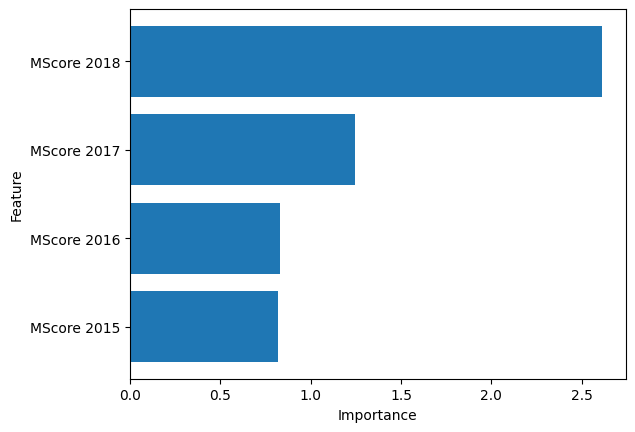

In [31]:
importance = lr.coef_[0]
importance=np.sort(importance)

sn.set_style()
plt.barh([i for i in range (len(importance))], importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
list_ticks, features_names = [], []
for i in range(0, year_widget.value - 2014):
    list_ticks.append(i)
    features_names.append('MScore '+str(2015 + i))
plt.yticks(list_ticks, features_names)
plt.show()

### Decision Tree

In [32]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, np.ravel(y_train))
print_performances('Decision Tree Classifier', dtc, X_train, y_train, X_test, y_test)

Decision Tree Classifier
 - Train accuracy: 81.8%
 - Test accuracy: 82.2%

Test               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2432
           1       0.87      0.75      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



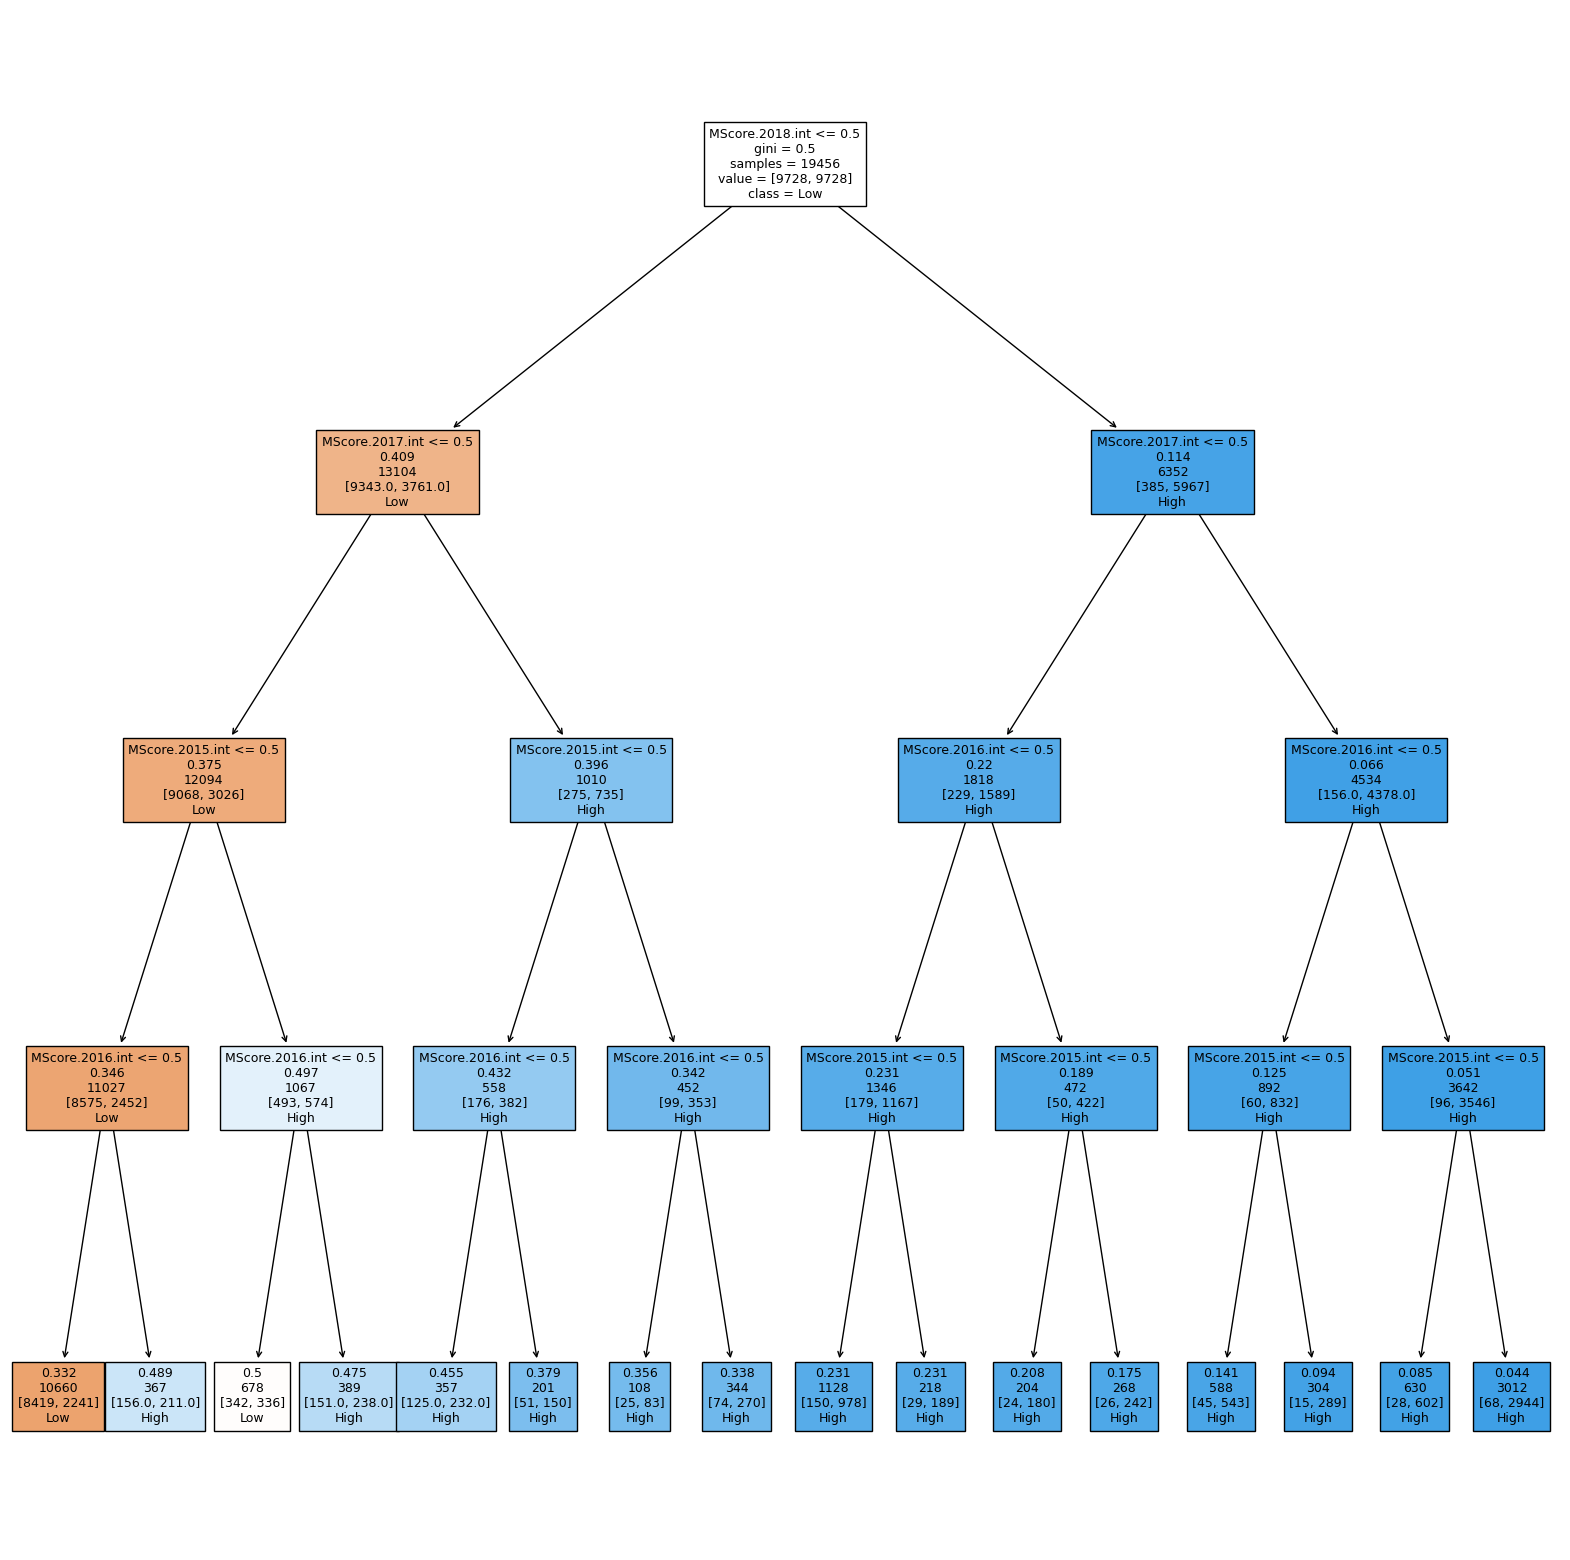

In [33]:
fig = plt.figure(figsize=(20,20))
tree.plot_tree(dtc, label='root', fontsize=9, class_names=['Low', 'High'], filled=True, feature_names=['MScore.2015.int', 'MScore.2016.int','MScore.2017.int','MScore.2018.int', 'MScore.2019.int']);

### Random Forest

In [34]:
rfc = RandomForestClassifier(n_estimators = 1000)
rfc.fit(X_train, np.ravel(y_train))
print_performances('Random Forest Classifier', rfc, X_train, y_train, X_test, y_test)

Random Forest Classifier
 - Train accuracy: 81.8%
 - Test accuracy: 82.2%

Test               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2432
           1       0.87      0.75      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



### Support Vector

In [35]:
svc = SVC(kernel='poly', random_state=0)
svc.fit(X_train, np.ravel(y_train))
print_performances('Support Vector Classifier', svc, X_train, y_train, X_test, y_test)

Support Vector Classifier
 - Train accuracy: 81.8%
 - Test accuracy: 82.2%

Test               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2432
           1       0.87      0.75      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



### Models comparison through ROC curves

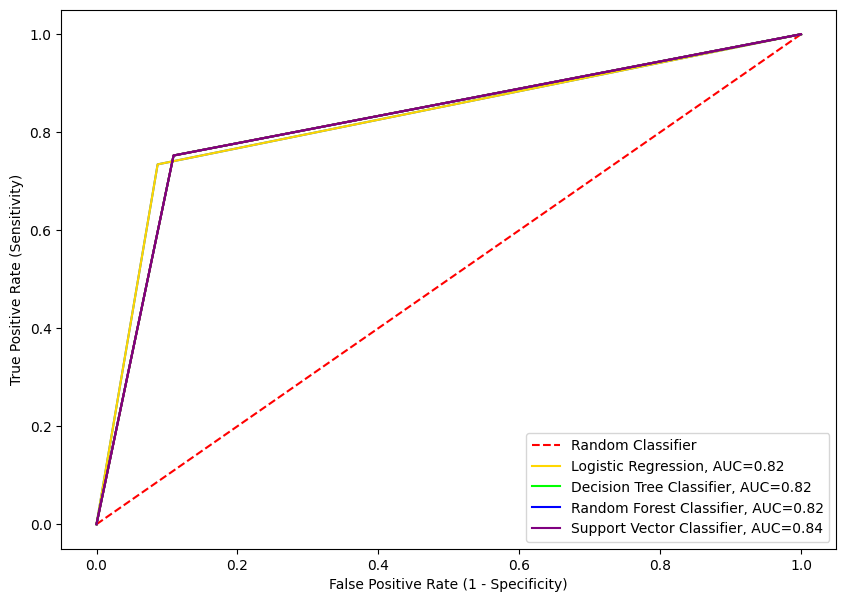

In [38]:
plt.figure(0, figsize=(10, 7)).clf()

colors = ['#ff0000', '#ffd700', '#00ff00', '#0000ff', '#800080']

# Random Classifier
random_fpr, random_tpr, _ = metrics.roc_curve(y_test, [0 for _ in range(len(y_test))])
plt.plot(random_fpr, random_tpr, linestyle='--', color=colors[0], label='Random Classifier')

# Logistic Regression
y_pred = lr.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[1], label='Logistic Regression, AUC='+str(auc))

# Decision Tree Classifier
y_pred = dtc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[2], label='Decision Tree Classifier, AUC='+str(auc))

# Random Forest Classifier
y_pred = rfc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[3], label='Random Forest Classifier, AUC='+str(auc))

# Support Vector Classifier
y_pred = svc.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[4], label='Support Vector Classifier, AUC='+'0.84')

plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()
plt.show();